In [27]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix

# TensorFlow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

print(tf.__version__)

2.15.0


**Loading Dataset**


In [13]:
dataset = {
             "train_data" : "/kaggle/input/100-bird-species/train",
             "valid_data" : "/kaggle/input/100-bird-species/valid",
             "test_data" : "/kaggle/input/100-bird-species/test"
          }

all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)
        
        
    all_data.append(data.copy())
    data.clear()

    
    
train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imgpath'])))
valid_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imgpath'])))
test_df = pd.DataFrame(all_data[2] , index=range(len(all_data[2]['imgpath'])))


# #Convert labels to numbers
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
valid_df['encoded_labels'] = lb.fit_transform(valid_df['labels'])
test_df['encoded_labels'] = lb.fit_transform(test_df['labels'])

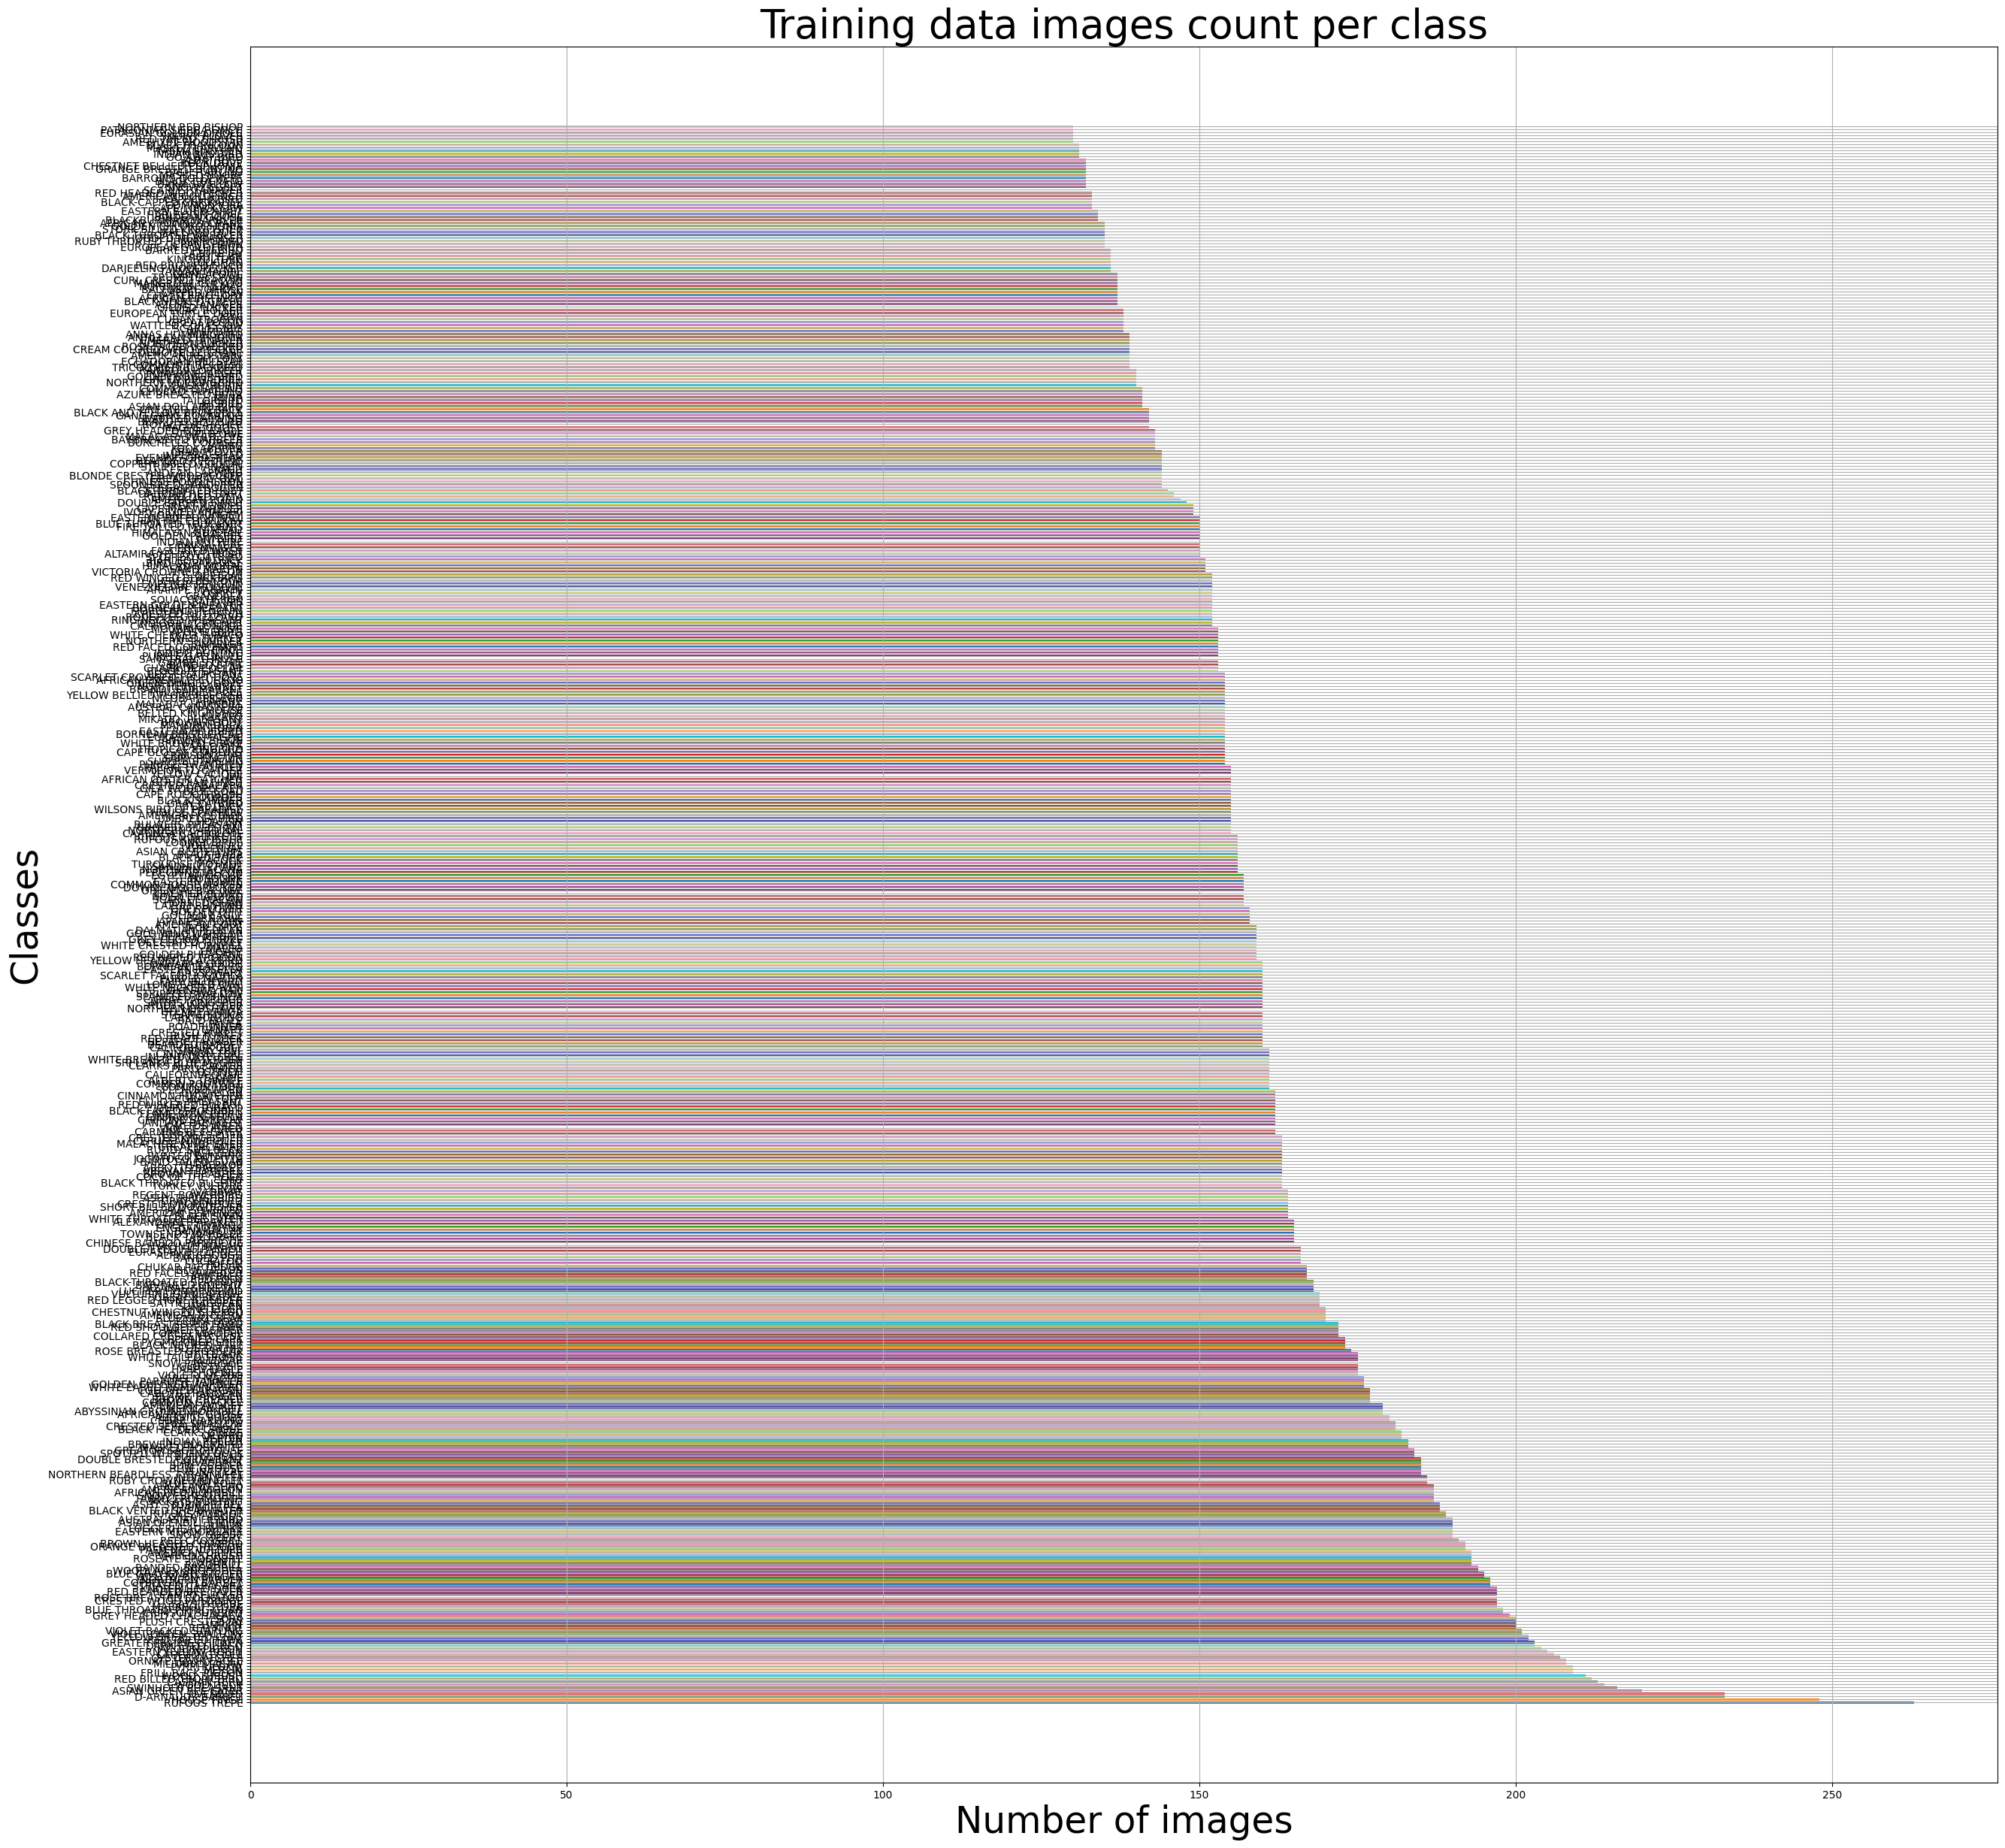

In [14]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(30,30))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()

In [15]:
train_df.sample(n=15, random_state=1)

imgpath  \
16216  /kaggle/input/100-bird-species/train/BROWN HEA...   
57889  /kaggle/input/100-bird-species/train/LIMPKIN/1...   
662    /kaggle/input/100-bird-species/train/CARMINE B...   
80302  /kaggle/input/100-bird-species/train/BLUE DACN...   
20487  /kaggle/input/100-bird-species/train/MOURNING ...   
83985  /kaggle/input/100-bird-species/train/EUROPEAN ...   
40795  /kaggle/input/100-bird-species/train/ANDEAN GO...   
9238   /kaggle/input/100-bird-species/train/FIORDLAND...   
1646   /kaggle/input/100-bird-species/train/PALM NUT ...   
51344  /kaggle/input/100-bird-species/train/WOODLAND ...   
53124  /kaggle/input/100-bird-species/train/NORTHERN ...   
63727  /kaggle/input/100-bird-species/train/SNOWY SHE...   
54464  /kaggle/input/100-bird-species/train/SCARLET M...   
58026  /kaggle/input/100-bird-species/train/LIMPKIN/0...   
45406  /kaggle/input/100-bird-species/train/NOISY FRI...   

                     labels  encoded_labels  
16216  BROWN HEADED COWBIRD             111  
57889               LIMPKIN             328  
662       CARMINE BEE-EATER             133  
80302           BLUE DACNIS              96  
20487         MOURNING DOVE             350  
83985    EUROPEAN GOLDFINCH             217  
40795          ANDEAN GOOSE              26  
9238      FIORDLAND PENGUIN             226  
1646       PALM NUT VULTURE             378  
51344   WOODLAND KINGFISHER             518  
53124       NORTHERN PARULA             362  
63727      SNOWY SHEATHBILL             454  
54464         SCARLET MACAW             444  
58026               LIMPKIN             328  
45406       NOISY FRIARBIRD             353

In [16]:
print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath             labels
0  /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
1  /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
2  /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
3  /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
4  /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
(84635, 3)
--------Validation----------
                                             imgpath             labels
0  /kaggle/input/100-bird-species/valid/DALMATIAN...  DALMATIAN PELICAN
1  /kaggle/input/100-bird-species/valid/DALMATIAN...  DALMATIAN PELICAN
2  /kaggle/input/100-bird-species/valid/DALMATIAN...  DALMATIAN PELICAN
3  /kaggle/input/100-bird-species/valid/DALMATIAN...  DALMATIAN PELICAN
4  /kaggle/input/100-bird-species/valid/DALMATIAN...  DALMATIAN PELICAN
(2625, 3)
----------Test--------------
                            

**Show sample from data**

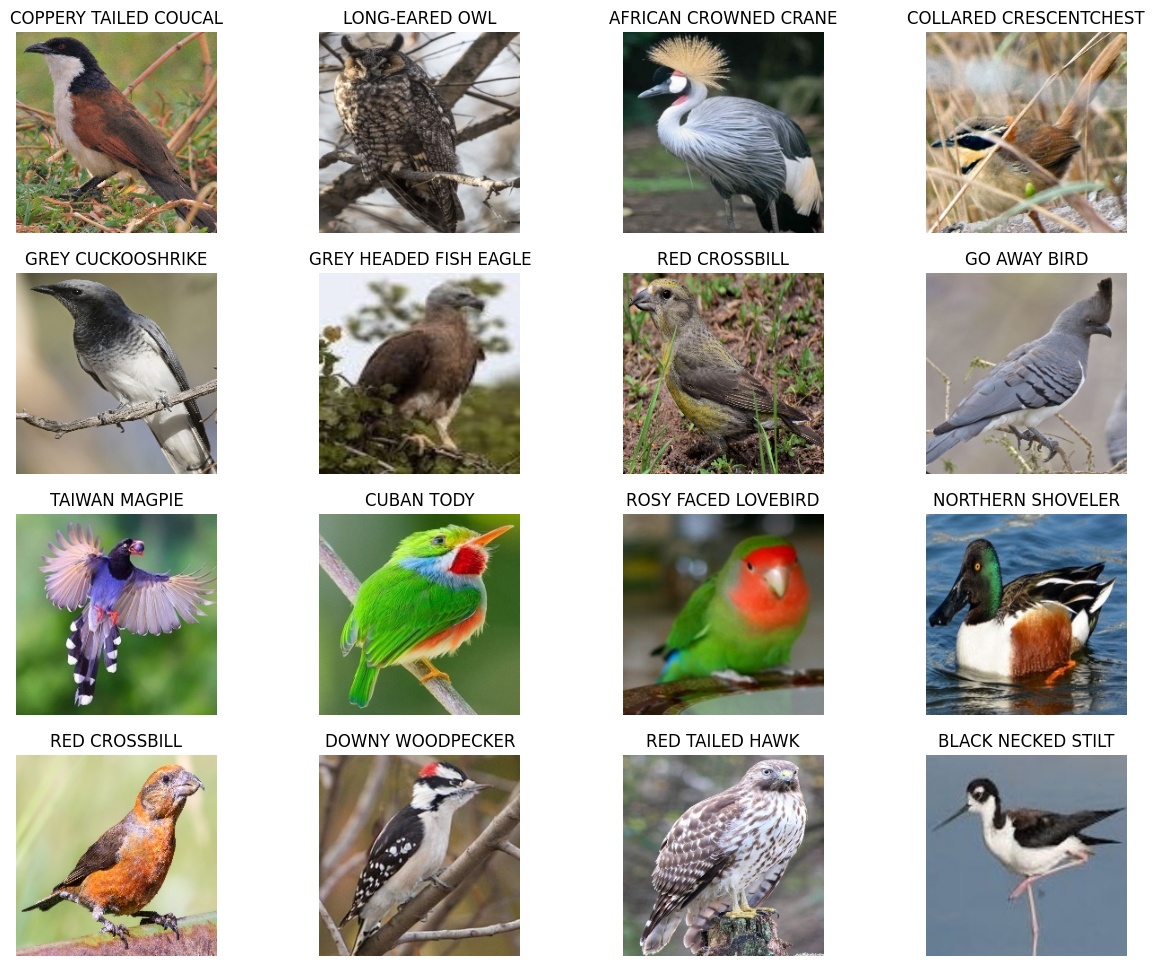

In [17]:
plt.figure(figsize=(15,12))
for i, row in valid_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

**Creating Dataloaders**

In [18]:
%%time

BATCH_SIZE = 35
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    # there could be image augmentation here
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 84635 validated image filenames belonging to 525 classes.
Found 2625 validated image filenames belonging to 525 classes.
Found 2625 validated image filenames belonging to 525 classes.
CPU times: user 1.32 s, sys: 1.51 s, total: 2.83 s
Wall time: 49 s


**Model Structure**

## EfficientNet

In [19]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB5(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

In [37]:

num_classes = len(set(train_images.classes))

# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.15),
  layers.RandomZoom(0.12),
  layers
    .RandomContrast(0.12),
], name='AugmentationLayer')

inputs = layers.Input(shape=(224, 224, 3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training=False)
x = layers.Dense(1024)(pretrain_out)
x = layers.Activation(activation="relu")(x) 
x = BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(512)(x)
x = layers.Activation(activation="relu")(x) 
x = BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AugmentationLayer (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb5 (Functional)     │ (None, 2048)           │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 525)            │       269,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activationLayer (Activation)    │ (None, 525)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,411,972 (119.83 MB)

 Trainable params: 2,895,373 (11.04 MB)

 Non-trainable params: 28,516,599 (108.78 MB)

None


**Training : Transfer Learning**

In [40]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)

Epoch 1/10
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 423s 175ms/step - accuracy: 0.6513 - loss: 1.3866 - val_accuracy: 0.8808 - val_loss: 0.4735 - learning_rate: 2.0000e-05
Epoch 2/10
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 0s 132us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 2.0000e-05
Epoch 3/10
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 422s 174ms/step - accuracy: 0.6732 - loss: 1.2989 - val_accuracy: 0.8869 - val_loss: 0.4525 - learning_rate: 4.0000e-06


**Display model performance**

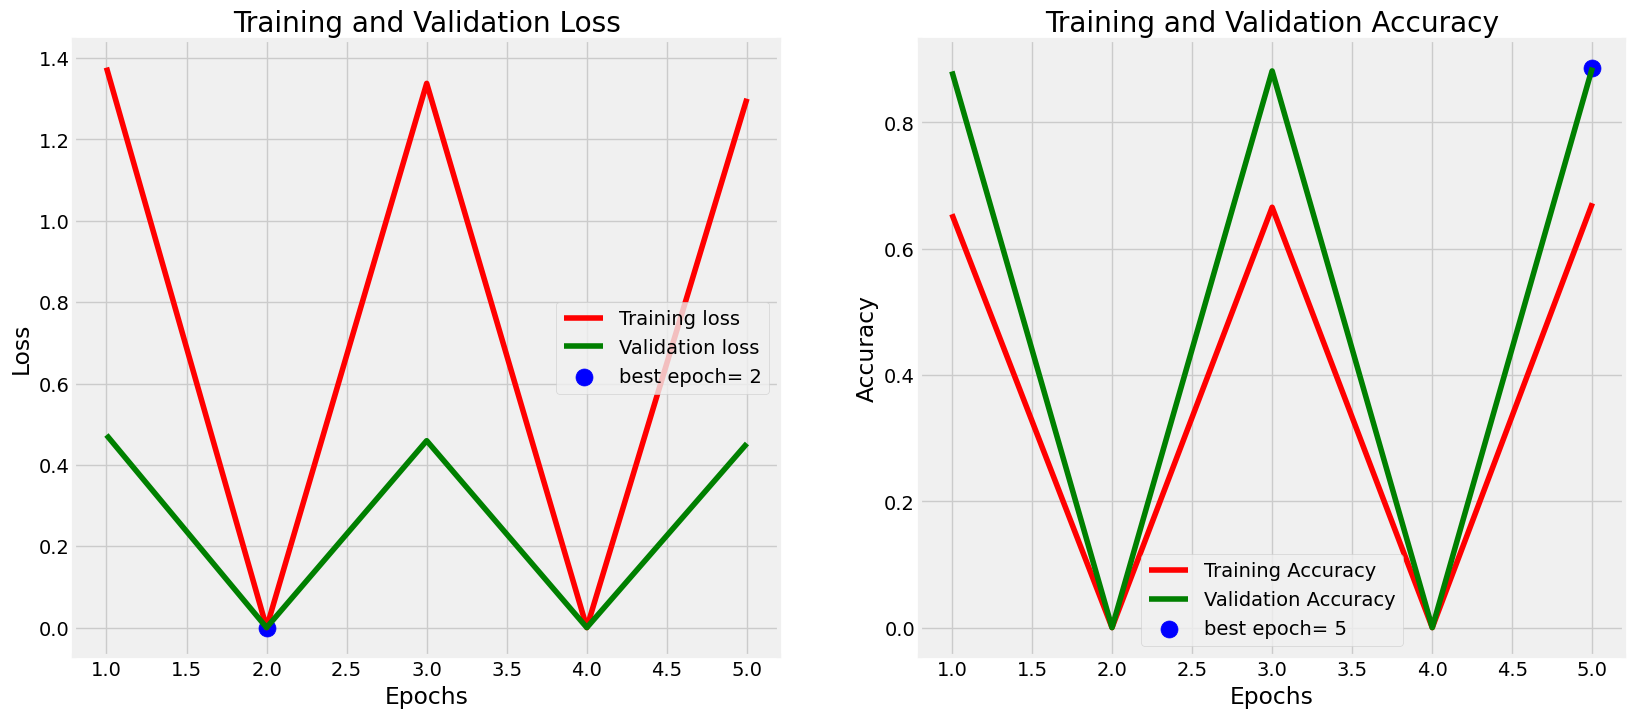

In [41]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

**Training : Fine Tuning**

In [43]:
pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False
        
# let`s see first 10 layers
for l in pretrained_model.layers[:10]:
    print(l.name, l.trainable)

model.compile(
    optimizer=Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=20,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)


input_layer_1 False
rescaling_2 False
normalization_1 False
rescaling_3 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AugmentationLayer (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb5 (Functional)     │ (None, 2048)           │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 525)            │       269,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activationLayer (Activation)    │ (None, 525)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,411,972 (119.83 MB)

 Trainable params: 2,895,373 (11.04 MB)

 Non-trainable params: 28,516,599 (108.78 MB)

None
Epoch 1/20


2024-04-08 09:06:43.531881: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetb5_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2419/2419 ━━━━━━━━━━━━━━━━━━━━ 452s 176ms/step - accuracy: 0.6658 - loss: 1.3372 - val_accuracy: 0.8876 - val_loss: 0.4537 - learning_rate: 1.0000e-05
Epoch 2/20
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 1s 261us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 3/20
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 421s 174ms/step - accuracy: 0.6753 - loss: 1.3048 - val_accuracy: 0.8876 - val_loss: 0.4475 - learning_rate: 1.0000e-05
Epoch 4/20
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 0s 41us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 5/20
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 421s 174ms/step - accuracy: 0.6759 - loss: 1.2931 - val_accuracy: 0.8869 - val_loss: 0.4456 - learning_rate: 2.0000e-06


**Display model performance**

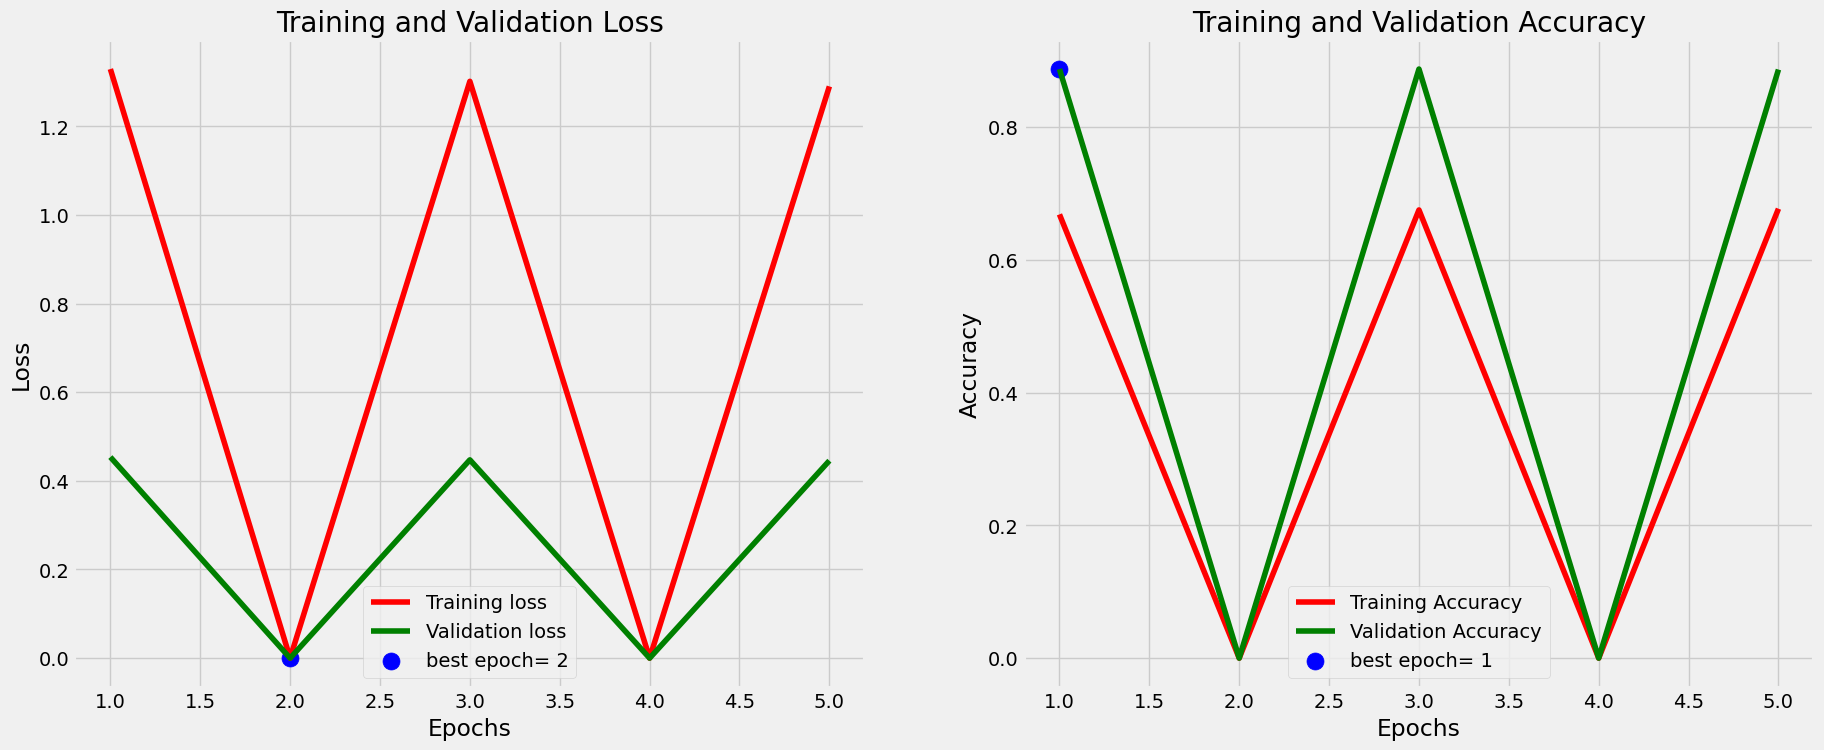

In [44]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

**model.evaluate**

In [45]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.37545
Test Accuracy: 90.40%


**F1 Score / Recall / Precision**

In [46]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step
F1 Score: 0.9013199181770609
                               precision    recall  f1-score   support

              ABBOTTS BABBLER       0.80      0.80      0.80         5
                ABBOTTS BOOBY       1.00      0.60      0.75         5
   ABYSSINIAN GROUND HORNBILL       1.00      1.00      1.00         5
        AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
       AFRICAN EMERALD CUCKOO       1.00      0.80      0.89         5
            AFRICAN FIREFINCH       1.00      1.00      1.00         5
       AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
        AFRICAN PIED HORNBILL       1.00      1.00      1.00         5
          AFRICAN PYGMY GOOSE       0.83      1.00      0.91         5
                    ALBATROSS       0.71      1.00      0.83         5
               ALBERTS TOWHEE       1.00      1.00      1.00         5
         ALEXANDRINE PARAKEET       1.00      0.80      0.89         5
     

**Get Predictions**

In [47]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))), 
                            "Test Labels" : test_images.labels, 
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step


Image Index  Test Labels             Test Classes  Prediction Labels  \
0            0          185        DALMATIAN PELICAN                185   
1            1          185        DALMATIAN PELICAN                185   
2            2          185        DALMATIAN PELICAN                185   
3            3          185        DALMATIAN PELICAN                185   
4            4          185        DALMATIAN PELICAN                185   
5            5           75  BLACK BREASTED PUFFBIRD                 75   
6            6           75  BLACK BREASTED PUFFBIRD                482   
7            7           75  BLACK BREASTED PUFFBIRD                 75   

        Prediction Classes                                               Path  \
0        DALMATIAN PELICAN  /kaggle/input/100-bird-species/test/DALMATIAN ...   
1        DALMATIAN PELICAN  /kaggle/input/100-bird-species/test/DALMATIAN ...   
2        DALMATIAN PELICAN  /kaggle/input/100-bird-species/test/DALMATIAN ...   
3        DALMATIAN PELICAN  /kaggle/input/100-bird-species/test/DALMATIAN ...   
4        DALMATIAN PELICAN  /kaggle/input/100-bird-species/test/DALMATIAN ...   
5  BLACK BREASTED PUFFBIRD  /kaggle/input/100-bird-species/test/BLACK BREA...   
6             TREE SWALLOW  /kaggle/input/100-bird-species/test/BLACK BREA...   
7  BLACK BREASTED PUFFBIRD  /kaggle/input/100-bird-species/test/BLACK BREA...   

   Prediction Probability  
0                0.999175  
1                0.999377  
2                0.999727  
3                0.999901  
4                0.999085  
5                0.980356  
6                0.830150  
7                0.718035

**Print the most confident errors**

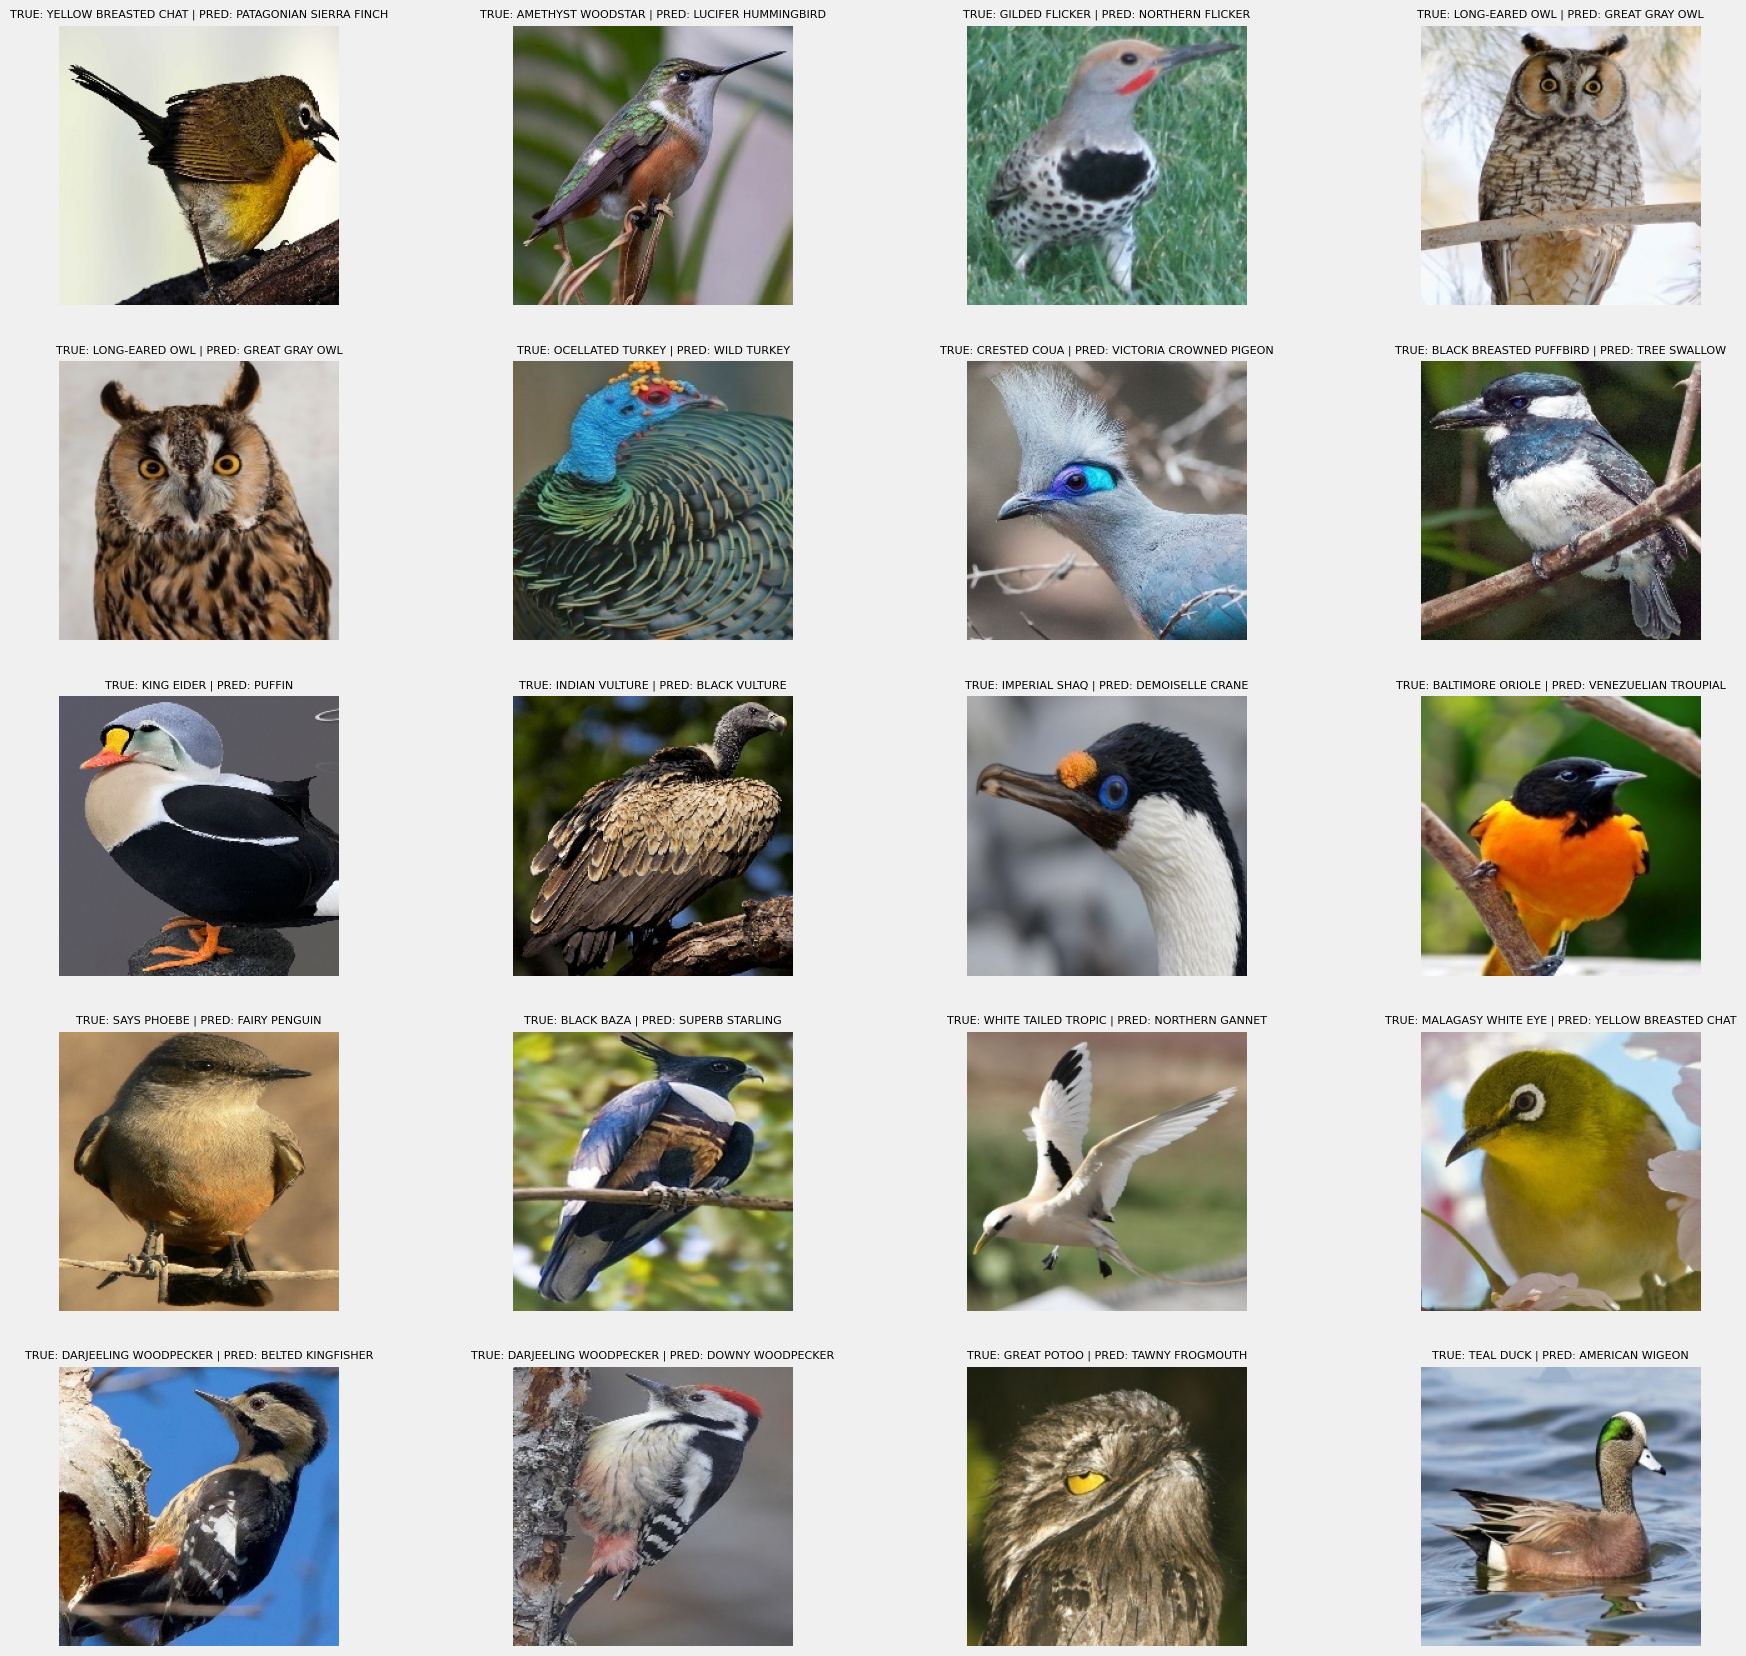

In [48]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')
    
plt.show()